📌 Linear SVM Results
Accuracy: 0.808695652173913
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       103
           1       0.83      0.82      0.83       127

    accuracy                           0.81       230
   macro avg       0.81      0.81      0.81       230
weighted avg       0.81      0.81      0.81       230

Cross-Validation Accuracy: 0.7771739130434783

📌 RBF SVM Results
Accuracy: 0.808695652173913
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       103
           1       0.81      0.86      0.83       127

    accuracy                           0.81       230
   macro avg       0.81      0.80      0.80       230
weighted avg       0.81      0.81      0.81       230

Cross-Validation Accuracy: 0.7760869565217392

🎯 Tuning RBF SVM with GridSearchCV...
✅ Best Parameters: {'C': 1, 'gamma': 0.1}
✅ Best CV Score: 0.8043478260

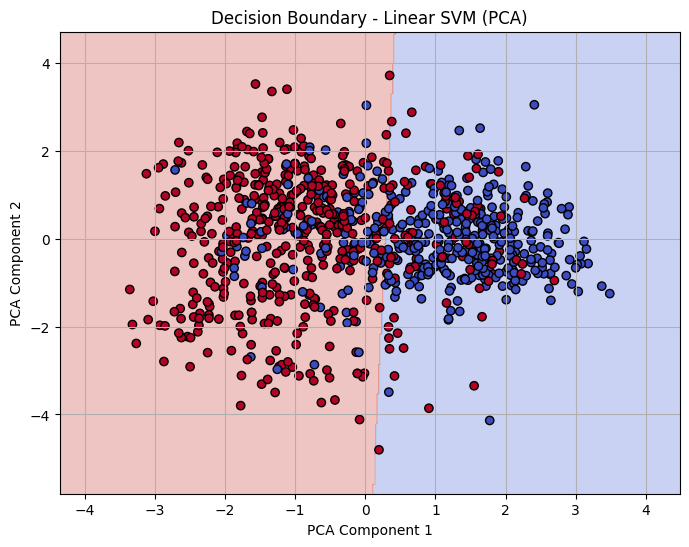

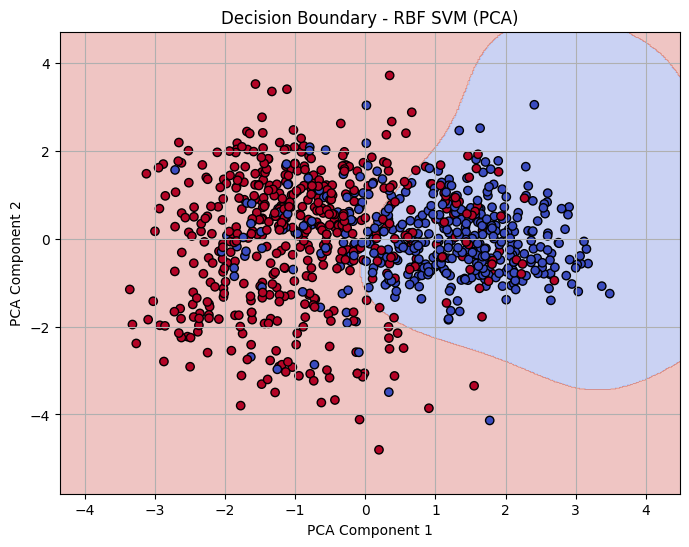

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Optional for notebooks
# %matplotlib inline

# Step 1: Load the dataset
try:
    df = pd.read_csv("heart_disease_uci.csv")  # Make sure file is in the same directory
except FileNotFoundError:
    raise FileNotFoundError("❌ File not found. Please upload 'heart_disease_uci.csv' to the current directory.")

# Step 2: Clean and prepare dataset
df_clean = df.drop(columns=["id", "dataset", "ca", "thal", "slope"], errors='ignore')
df_clean = df_clean.dropna(subset=["num"])
df_clean["target"] = df_clean["num"].apply(lambda x: 0 if x == 0 else 1)
df_clean = df_clean.drop(columns=["num"])

# Encode categorical columns
categorical_cols = df_clean.select_dtypes(include="object").columns
for col in categorical_cols:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

# Separate features and target
X = df_clean.drop(columns="target")
y = df_clean["target"]

# Step 3: Handle missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 5: Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

# Step 7: Train SVM with linear kernel
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

# Evaluation - Linear
print("📌 Linear SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Classification Report:\n", classification_report(y_test, y_pred_linear))
print("Cross-Validation Accuracy:", cross_val_score(svm_linear, X_scaled, y, cv=5).mean())

# Step 8: Train SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluation - RBF
print("\n📌 RBF SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))
print("Cross-Validation Accuracy:", cross_val_score(svm_rbf, X_scaled, y, cv=5).mean())

# Step 9: Hyperparameter tuning for RBF kernel
print("\n🎯 Tuning RBF SVM with GridSearchCV...")
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Score:", grid_search.best_score_)

# Step 10: Visualize decision boundary using PCA
def plot_decision_boundary(model, X, y, title):
    h = .02  # Mesh step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# Visualize using PCA projections
svm_vis_linear = SVC(kernel='linear', C=1.0)
svm_vis_linear.fit(X_pca, y)
plot_decision_boundary(svm_vis_linear, X_pca, y, "Decision Boundary - Linear SVM (PCA)")

svm_vis_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_vis_rbf.fit(X_pca, y)
plot_decision_boundary(svm_vis_rbf, X_pca, y, "Decision Boundary - RBF SVM (PCA)")
